<a href="https://colab.research.google.com/github/priyanshusankhala/hasoc-hnlp/blob/main/English_subtaskB_experiment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing libraires

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/HASOC/

/content/drive/MyDrive/HASOC


In [ ]:
ls

Analysis/            model/               __pycache__/
Bert-large-cased-0/  predictionstrue.txt  task1_baseline.py
Data/                predictions.txt      train_hi_sent.csv


In [ ]:
! pip install transformers
! pip install neptune-client

     |████████████████████████████████| 2.6 MB 5.3 MB/s 
     |████████████████████████████████| 636 kB 57.9 MB/s 
     |████████████████████████████████| 895 kB 61.6 MB/s 
     |████████████████████████████████| 3.3 MB 36.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 253 kB 5.4 MB/s 
     |████████████████████████████████| 829 kB 37.2 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 170 kB 41.7 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 129 kB 53.0 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.10.6-py2.py3-none-any.whl size=433273 sha256=6c51aa55911d28a243709bdc96a1c14bca1e516c4079de35a9f2ba190e702b22
  Stored in directory: /root/.cache/pip/wheels/a6

In [ ]:
###############################################################

# baseline code for task 1
# using BERT-based classification
# With the exception of the evaluation part 
# (which reflects the tasks evaluation code), 
# this code is taken from
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/

###############################################################


import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
import numpy as np
import torch
import torch.nn as nn
import time
import datetime
import random
import os
import os.path
from sklearn import metrics
import neptune
load_model = False
save_model = False

if load_model:
    output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_file.bin"
    output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_file.bin"
    output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_file.bin"


ModuleNotFoundError: ignored

Pre-proessing

In [ ]:
import pandas as pd

# Load the dataset into a pandas dataframe.
#data = pd.read_csv("/content/drive/MyDrive/HASOC/Data/1B_English_GOLD.csv", delimiter=',')
data = pd.ExcelFile("/content/drive/MyDrive/HASOC/Data/1B_English_GOLD.xlsx")
# dev_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_train.csv", delimiter=',', header=None, names=['id', 'sentence', 'label', 'alpha'])


In [ ]:
data.task_1 = data.task_1.str.replace('NOT','0')
data.task_1 = data.task_1.str.replace('HOF','1')
data.task_1 = data.task_1.astype(int)

In [ ]:
df2 = data.copy()
df = df2.sample(frac=0.8, random_state=0)
dev_df = df2.drop(df.index)

In [ ]:
#1 df.head()
data.head()
#data.value_counts()

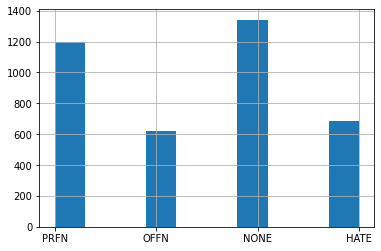

In [ ]:
import matplotlib.pyplot as plt

data.task_2.hist()

In [ ]:
data['task_2'].value_counts(normalize=True) * 100

NONE    34.920635
PRFN    31.121520
HATE    17.772574
OFFN    16.185272
Name: task_2, dtype: float64

In [ ]:
# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))


Number of training sentences: 3,074



In [ ]:
# Get the lists of sentences and their labels.
sentences = df.text.values
labels = df.task_1.values
labels

array([0, 1, 1, ..., 0, 0, 1])

In [ ]:
# Get the lists of sentences and their labels.
dev_sentences = dev_df.text.values
dev_labels = dev_df.task_1.values

Model

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
if load_model:
    tokenizer = BertTokenizer.from_pretrained(output_vocab_file, do_lower_case = False)
else:
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
dev_input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# For every sentence...
for sent in dev_sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    # Add the encoded sentence to the list.
    dev_input_ids.append(encoded_sent)

Loading BERT tokenizer...


NameError: ignored

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
l = [len(x) for x in input_ids]

In [ ]:
np.quantile(l, 0.98)

110.0

(array([1.106e+03, 1.364e+03, 5.590e+02, 4.200e+01, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([  4. ,  41.2,  78.4, 115.6, 152.8, 190. , 227.2, 264.4, 301.6,
        338.8, 376. ]),
 <a list of 10 Patch objects>)

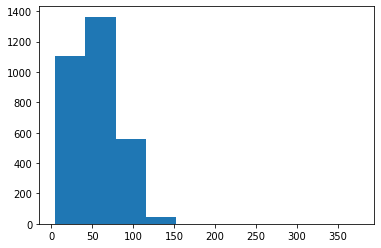

In [ ]:
np.histogram(l)
plt.hist(l)

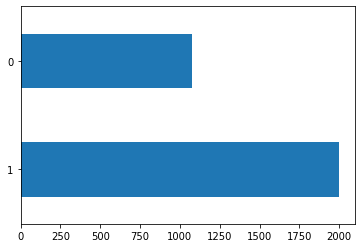

In [ ]:
df['task_1'].value_counts()[:].plot(kind='barh')

In [ ]:

    
# We'll borrow the `pad_sequences` utility function to do this.

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 120

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

dev_input_ids = pad_sequences(dev_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Create attention masks
attention_masks = []
dev_attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

# For each sentence...
for sent in dev_input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    dev_attention_masks.append(att_mask)
    

# Use 90% for training and 10% for validation.
train_inputs = input_ids 
validation_inputs = dev_input_ids
train_labels = labels
validation_labels = dev_labels

# Do the same for the masks.
train_masks =  attention_masks
validation_masks = dev_attention_masks
                                             
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs).to(torch.int64)
validation_inputs = torch.tensor(validation_inputs).to(torch.int64)

train_labels = torch.tensor(train_labels).to(torch.int64)
validation_labels = torch.tensor(validation_labels).to(torch.int64)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

if load_model:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top.
    config = BertConfig.from_json_file(output_config_file)
    model = BertForSequenceClassification(config)
    state_dict = torch.load(output_model_file)
    model.load_state_dict(state_dict)

else: 
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-cased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.cuda()
print(device)


# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    
learning_rate = 2e-5
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
use_neptune = 1                                            
if use_neptune:
    api = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NDRkYTliMS1lZGRjLTRhOWMtOGU0ZC04OTEzNzU1Y2E2Y2MifQ=="
    neptune.init(project_qualified_name='hnlp.hasoc/nlp', api_token=api)
    PARAMS = {'lr': learning_rate,}
    tags = ['bert']
    neptune.create_experiment("First_exp", tags=tags, params=PARAMS)
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
    

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
criterion = nn.CrossEntropyLoss(weight = torch.Tensor([2/3,1/3]).to(device))
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    #new
    train_loss = []
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device).long()

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        logits = outputs[0]
        loss = criterion(logits,b_labels)
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        neptune.log_metric("Loss_Train",loss.item())
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        #new
        train_loss.append(loss.item())
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  training loss: {0:.2f}".format(train_loss))
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1
        neptune.log_metric("Acc_Val",tmp_eval_accuracy)
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    func_call_test(epoch_i)
print("")
print("Training complete!")




Padding/truncating all sentences to 120 values...

Padding token: "[PAD]", ID: 0

Done.


Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

cpu
The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (28996, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias           

Info (NVML): Driver Not Loaded. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/hnlp.hasoc/nlp/e/NLP-4

======== Epoch 1 / 4 ========
Training...
  Batch    40  of    385.    Elapsed: 0:06:58.
  Batch    80  of    385.    Elapsed: 0:13:46.
  Batch   120  of    385.    Elapsed: 0:20:36.
  Batch   160  of    385.    Elapsed: 0:27:32.
  Batch   200  of    385.    Elapsed: 0:34:15.
  Batch   240  of    385.    Elapsed: 0:40:55.
  Batch   280  of    385.    Elapsed: 0:47:31.
  Batch   320  of    385.    Elapsed: 0:54:09.


In [ ]:
# torch.save(model,'model.pth')
# model = torch.load('model.pth')
# Load the dataset into a pandas dataframe.
def func_call_test(epoch_id):
    test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',') #, header=None, names=['id', 'sentence', 'label']
    # data.task_1 = data.task_1.str.replace('NOT','0')
    # data.task_1 = data.task_1.str.replace('HOF','1')
    # data.task_1 = data.task_1.astype(int)
    test_sentences = test_df.sentence.values
    test_labels = test_df.label.values
    # Report the number of sentences.
    print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))
    # /Check This
    # Will this make sense now?
    # Since the files are no longer loading with the gives headers. Think about it and give the necessary loading names
    # /
    # /test_sentences = test_df.sentence.values ##
    # /test_labels = test_df.label.values
    # / UNcomment/delete after done
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    test_input_ids = []

    # For every sentence...
    for sent in test_sentences:
        # `encode` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
        
        test_input_ids.append(encoded_sent)

    # Pad our input tokens
    test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                              dtype="long", truncating="post", padding="post")

    # Create attention masks
    test_attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in test_input_ids:
      seq_mask = [float(i>0) for i in seq]
      test_attention_masks.append(seq_mask) 

    # Convert to tensors.
    prediction_inputs = torch.tensor(test_input_ids).to(torch.int64)
    prediction_masks = torch.tensor(test_attention_masks)
    prediction_labels = torch.tensor(test_labels).to(torch.int64)

    # Set the batch size.  
    batch_size = 8  

    # Create the DataLoader.
    prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

    # Prediction on test set

    print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions , true_labels = [], []
   
    # Predict 
    for batch in prediction_dataloader:
      # Add batch to GPU
      batch = tuple(t.to(device) for t in batch)
      
      # Unpack the inputs from our dataloader
      b_input_ids, b_input_mask, b_labels = batch
      
      # Telling the model not to compute or store gradients, saving memory and 
      # speeding up prediction
      with torch.no_grad():
          # Forward pass, calculate logit predictions
          outputs = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

      logits = outputs[0]

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()
      
      # Store predictions and true labels
      predictions.append(logits)
      true_labels.append(label_ids)

    print('    DONE.')

    print('Positive samples: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))
    with open('/content/drive/MyDrive/HASOC/Data/predictionstrue1.csv', "w") as writer:
        for i,line in enumerate(predictions):
            writer.write(str(line) +" " +str(true_labels[i]) + "\n")
      
    # Combine the predictions for each batch into a single list of 0s and 1s.
    flat_predictions = [item for sublist in predictions for item in sublist]
    flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

    # Combine the correct labels for each batch into a single list.
    flat_true_labels = [item for sublist in true_labels for item in sublist]

    def evaluate(y_true, y_pred):
        """
        Evaluate Precision, Recall, F1 scores between y_true and y_pred
        If output_file is provided, scores are saved in this file otherwise printed to std output.
        :param y_true: true labels
        :param y_pred: predicted labels
        :return: list of scores (F1, Recall, Precision, ExactMatch)
        """
        
        assert len(y_true) == len(y_pred)
        precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
        scores = [
            "F1: %f\n" % f1,
            "Recall: %f\n" % recall,
            "Precision: %f\n" % precision,
            "ExactMatch: %f\n" % -1.0
        ]
        for s in scores:
            print(s, end='')

    # Evaluate predictions    
    evaluate(flat_true_labels, flat_predictions)

    print('Writing predictions to file...')
    with open("/content/drive/MyDrive/HASOC/Data/statout"+epoch_i+".csv", "w") as writer:
      for line in flat_predictions:
            writer.write(str(line) + "\n")
    #//Check this    
   #// You had to interchange these two
    # Save predictions to file
    with open('/content/drive/MyDrive/HASOC/Data/predictions1.csv', "w") as writer:
        for line in flat_predictions:
            writer.write(str(line) + "\n")
            
    print('Done writing predictions...')


    if(save_model):
        v = 0
        folder_name = "Bert-large-cased-" + str(v)
        if(os.path.exists(folder_name)):
            v+=1
            folder_name = "Bert-large-uncased-" + str(v)
        else:
            os.mkdir(folder_name)

        # output_model_file = "./{}/my_own_model_file.bin".format(folder_name)
        # output_config_file = "./{}/my_own_config_file.bin".format(folder_name)
        # output_vocab_file = "./{}/my_own_vocab_file.bin".format(folder_name)
        output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_file.bin".format(model)
        output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_file.bin".format(model)
        output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_file.bin".format(model)

        # Step 1: Save a model, configuration and vocabulary that you have fine-tuned

        # If we have a distributed model, save only the encapsulated model
        # (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
        model_to_save = model.module if hasattr(model, 'module') else model

        torch.save(model_to_save.state_dict(), output_model_file)
        model_to_save.config.to_json_file(output_config_file)
        tokenizer.save_vocabulary(output_vocab_file)

In [ ]:

# Create sentence and label lists


In [ ]:
######################## Ignore this cell #####################################

# # tokenizer
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences

# tokenizer = Tokenizer(num_words=100, lower= 1, oov_token="<OOV>")
# tokenizer.fit_on_texts(sentences)
# word_index = tokenizer.word_index
# print(word_index)
# #{'<OOV>': 1, 'i': 2, 'to': 3, 'play': 4, 'no': 5, 'want': 6, 'go': 7, 'out': 8, 'like': 9, 'eating': 10}

# sequences = tokenizer.texts_to_sequences(sentences)
# print(sentences)
# print(word_index)
# print(sequences)

# # pre padding
# pre_pad = pad_sequences(sequences, padding='pre')
# print("\nword_index = ", word_index)
# print("\nsequences = ", sequences)
# print("\npadded_seq = " )
# print(pre_pad)

# # post padding
# post_pad = pad_sequences(sequences, padding='post')
# print("\nword_index = ", word_index)
# print("\nsequences = ", sequences)
# print("\npadded_seq = " )
# print(post_pad)

# import seaborn as sns
# ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

# plt.title('MCC Score per Batch')
# plt.ylabel('MCC Score (-1 to +1)')
# plt.xlabel('Batch #')

# plt.show()



### New section

In [ ]:
###############################################################

# baseline code for task 1
# using BERT-based classification
# With the exception of the evaluation part 
# (which reflects the tasks evaluation code), 
# this code is taken from
# https://mccormickml.com/2019/07/22/BERT-fine-tuning/

###############################################################


import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
import numpy as np
import torch
import torch.nn as nn
import time
import datetime
import random
import os
import os.path
from sklearn import metrics
import neptune
load_model = False
save_model = False

if load_model:
    output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_file.bin"
    output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_file.bin"
    output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_file.bin"
data.task_1 = data.task_1.str.replace('NOT','0')
data.task_1 = data.task_1.str.replace('HOF','1')
data.task_1 = data.task_1.astype(int)

df2 = data.copy()
df = df2.sample(frac=0.8, random_state=0)
dev_df = df2.drop(df.index)

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Get the lists of sentences and their labels.
sentences = df.text.values
labels = df.task_1.values
labels

# Get the lists of sentences and their labels.
dev_sentences = dev_df.text.values
dev_labels = dev_df.task_1.values

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
if load_model:
    tokenizer = BertTokenizer.from_pretrained(output_vocab_file, do_lower_case = False)
else:
    tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
dev_input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# For every sentence...
for sent in dev_sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
    
    # Add the encoded sentence to the list.
    dev_input_ids.append(encoded_sent)

# We'll borrow the `pad_sequences` utility function to do this.

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 120

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

dev_input_ids = pad_sequences(dev_input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

# Create attention masks
attention_masks = []
dev_attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

# For each sentence...
for sent in dev_input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    dev_attention_masks.append(att_mask)
    

# Use 90% for training and 10% for validation.
train_inputs = input_ids 
validation_inputs = dev_input_ids
train_labels = labels
validation_labels = dev_labels

# Do the same for the masks.
train_masks =  attention_masks
validation_masks = dev_attention_masks
                                             
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs).to(torch.int64)
validation_inputs = torch.tensor(validation_inputs).to(torch.int64)

train_labels = torch.tensor(train_labels).to(torch.int64)
validation_labels = torch.tensor(validation_labels).to(torch.int64)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

batch_size = 8

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

if load_model:
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top.
    config = BertConfig.from_json_file(output_config_file)
    model = BertForSequenceClassification(config)
    state_dict = torch.load(output_model_file)
    model.load_state_dict(state_dict)

else: 
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-cased", # Use the 12-layer BERT model, with an uncased vocab.
        num_labels = 2, # The number of output labels--2 for binary classification.
                        # You can increase this for multi-class tasks.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.cuda()
print(device)


# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))
print('==== Embedding Layer ====\n')
for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    
learning_rate = 2e-5
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
use_neptune = 1                                            
if use_neptune:
    api = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NDRkYTliMS1lZGRjLTRhOWMtOGU0ZC04OTEzNzU1Y2E2Y2MifQ=="
    neptune.init(project_qualified_name='hnlp.hasoc/nlp', api_token=api)
    PARAMS = {'lr': learning_rate,}
    tags = ['bert']
    neptune.create_experiment("First_exp", tags=tags, params=PARAMS)
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
    
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))
    

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
# Store the average loss after each epoch so we can plot them.
loss_values = []
criterion = nn.CrossEntropyLoss(weight = torch.Tensor([1/3,2/3]).to(device))
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    #new
    train_loss = []
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device).long()

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        logits = outputs[0]
        loss = criterion(logits,b_labels)
        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()
        neptune.log_metric("Loss_Train",loss.item())
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        #new
        train_loss.append(loss.item())
        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    #print("  training loss: {0:.2f}".format(train_loss))
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1
        neptune.log_metric("Acc_Val",tmp_eval_accuracy)
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    def func_call_test(epoch_id):
      #test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',') #, header=None, names=['id', 'sentence', 'label']
      test_df = pd.read_csv("/content/drive/MyDrive/HASOC/Data/en_Hasoc2021_test_task1.csv", delimiter=',', header=None, names=['id', 'sentence', 'label'])
      # data.task_1 = data.task_1.str.replace('NOT','0')
      # data.task_1 = data.task_1.str.replace('HOF','1')
      # data.task_1 = data.task_1.astype(int)
      test_sentences = test_df.sentence.values
      test_labels = test_df.label.values
      # Report the number of sentences.
      print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))
      # /Check This
      # Will this make sense now?
      # Since the files are no longer loading with the gives headers. Think about it and give the necessary loading names
      # /
      # /test_sentences = test_df.sentence.values ##
      # /test_labels = test_df.label.values
      # / UNcomment/delete after done
      # Tokenize all of the sentences and map the tokens to thier word IDs.
      test_input_ids = []

      # For every sentence...
      for sent in test_sentences:
          # `encode` will:
          #   (1) Tokenize the sentence.
          #   (2) Prepend the `[CLS]` token to the start.
          #   (3) Append the `[SEP]` token to the end.
          #   (4) Map tokens to their IDs.
          encoded_sent = tokenizer.encode(str(sent),add_special_tokens = True,)
          
          test_input_ids.append(encoded_sent)

      # Pad our input tokens
      test_input_ids = pad_sequences(test_input_ids, maxlen=MAX_LEN, 
                                dtype="long", truncating="post", padding="post")

      # Create attention masks
      test_attention_masks = []

      # Create a mask of 1s for each token followed by 0s for padding
      for seq in test_input_ids:
        seq_mask = [float(i>0) for i in seq]
        test_attention_masks.append(seq_mask) 

      # Convert to tensors.
      prediction_inputs = torch.tensor(test_input_ids).to(torch.int64)
      prediction_masks = torch.tensor(test_attention_masks)
      prediction_labels = torch.tensor(test_labels).to(torch.int64)

      # Set the batch size.  
      batch_size = 8  

      # Create the DataLoader.
      prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
      prediction_sampler = SequentialSampler(prediction_data)
      prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

      # Prediction on test set

      print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

      # Put model in evaluation mode
      model.eval()

      # Tracking variables 
      predictions , true_labels = [], []
    
      # Predict 
      for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs = model(b_input_ids, token_type_ids=None, 
                            attention_mask=b_input_mask)

        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

      print('    DONE.')

      print('Positive samples: %d of %d (%.2f%%)' % (test_df.label.sum(), len(test_df.label), (test_df.label.sum() / len(test_df.label) * 100.0)))
      with open('/content/drive/MyDrive/HASOC/Data/predictionstrue1.csv', "w") as writer:
          for i,line in enumerate(predictions):
              writer.write(str(line) +" " +str(true_labels[i]) + "\n")
        
      # Combine the predictions for each batch into a single list of 0s and 1s.
      flat_predictions = [item for sublist in predictions for item in sublist]
      flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

      # Combine the correct labels for each batch into a single list.
      flat_true_labels = [item for sublist in true_labels for item in sublist]

      def evaluate(y_true, y_pred):
          """
          Evaluate Precision, Recall, F1 scores between y_true and y_pred
          If output_file is provided, scores are saved in this file otherwise printed to std output.
          :param y_true: true labels
          :param y_pred: predicted labels
          :return: list of scores (F1, Recall, Precision, ExactMatch)
          """
          
          assert len(y_true) == len(y_pred)
          precision, recall, f1, _ = metrics.precision_recall_fscore_support(y_true, y_pred, labels=[0, 1], average='weighted')
          scores = [
              "F1: %f\n" % f1,
              "Recall: %f\n" % recall,
              "Precision: %f\n" % precision,
              "ExactMatch: %f\n" % -1.0
          ]
          for s in scores:
              print(s, end='')

      # Evaluate predictions    
      evaluate(flat_true_labels, flat_predictions)

      print('Writing predictions to file...')
      with open("/content/drive/MyDrive/HASOC/Data/statout"+str(epoch_i)+".csv", "w") as writer:
        for line in flat_predictions:
              writer.write(str(line) + "\n")
      #//Check this    
    #// You had to interchange these two
      # Save predictions to file
      with open('/content/drive/MyDrive/HASOC/Data/predictions1.csv', "w") as writer:
          for line in flat_predictions:
              writer.write(str(line) + "\n")
              
      print('Done writing predictions...')


      if(save_model):
          v = 0
          folder_name = "Bert-large-cased-" + str(v)
          if(os.path.exists(folder_name)):
              v+=1
              folder_name = "Bert-large-uncased-" + str(v)
          else:
              os.mkdir(folder_name)

          # output_model_file = "./{}/my_own_model_file.bin".format(folder_name)
          # output_config_file = "./{}/my_own_config_file.bin".format(folder_name)
          # output_vocab_file = "./{}/my_own_vocab_file.bin".format(folder_name)
          output_model_file = "/content/drive/MyDrive/HASOC/model/my_own_model_file.bin".format(model)
          output_config_file = "/content/drive/MyDrive/HASOC/model/my_own_config_file.bin".format(model)
          output_vocab_file = "/content/drive/MyDrive/HASOC/model/my_own_vocab_file.bin".format(model)

          # Step 1: Save a model, configuration and vocabulary that you have fine-tuned

          # If we have a distributed model, save only the encapsulated model
          # (it was wrapped in PyTorch DistributedDataParallel or DataParallel)
          model_to_save = model.module if hasattr(model, 'module') else model

          torch.save(model_to_save.state_dict(), output_model_file)
          model_to_save.config.to_json_file(output_config_file)
          tokenizer.save_vocabulary(output_vocab_file)

    func_call_test(epoch_i)
print("")
print("Training complete!")

# torch.save(model,'model.pth')
# model = torch.load('model.pth')
# Load the dataset into a pandas dataframe.


KeyboardInterrupt: ignored